# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


# Physics Informed Neural Network

In [2]:
class BiasLayer(nn.Module):
    def __init__(self):
        super(BiasLayer, self).__init__()
        # Define the bias as a learnable parameter
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, inputs):
        return inputs + self.bias

class DotProductLayer(nn.Module):
    def forward(self, inputs):
        branch, trunk = inputs
        return torch.sum(branch * trunk, dim=1, keepdim=True)

class GrossPitaevskiiPINN(nn.Module):
    """
    Physics-Informed Neural Network (PINN) for solving the 1D Gross-Pitaevskii Equation
    with DeepONet architecture.

    Parameters
    ----------
    layers : list of int
        Neural network architecture, each entry defines the number of neurons in that layer.
    hbar : float, optional
        Reduced Planck's constant (default is 1.0).
    m : float, optional
        Mass of the particle (default is 1.0).
    g : float, optional
        Interaction strength (default is 100.0).
    """
    def __init__(self, branch_layers, trunk_layers, hbar=1.0, m=1.0, g=100.0):
        super().__init__()
        self.branch_network = self.build_network(branch_layers)
        self.trunk_network = self.build_network(trunk_layers)
        self.g = g  # Interaction strength
        self.hbar = hbar  # Planck's constant, fixed
        self.m = m  # Particle mass, fixed

    def build_network(self, layers):
        """
        Build a network with specified layers using Tanh activation.

        Parameters
        ----------
        layers : list
            Neural network architecture, each entry defines the number of neurons in each layer.

        Returns
        -------
        nn.Sequential
            A PyTorch sequential model for the network.
        """
        network = []
        for i in range(len(layers) - 1):
            linear = nn.Linear(layers[i], layers[i + 1], bias=True)
            nn.init.xavier_uniform_(linear.weight)
            nn.init.zeros_(linear.bias)
            network.append(linear)
            if i < len(layers) - 2:
                network.append(nn.Tanh())
        return nn.Sequential(*network)

    def forward(self, function_input, spatial_input):
        """
        Forward pass through the DeepONet structure.

        Parameters
        ----------
        function_input : torch.Tensor
            Input tensor for the branch network (e.g., function coefficients).
        spatial_input : torch.Tensor
            Input tensor for the trunk network (e.g., spatial or temporal points).

        Returns
        -------
        torch.Tensor
            Output tensor representing the predicted solution.
        """
        branch_output = self.branch_network(function_input)
        trunk_output = self.trunk_network(spatial_input)
        return torch.sum(branch_output * trunk_output, dim=1, keepdim=True)

    def compute_potential(self, x, V0=1.0, x0=np.pi / 2, sigma=0.5):
        """
        Compute the Gaussian potential V(x).

        Parameters
        ----------
        inputs : torch.Tensor
            Input tensor of spatial coordinates x.
        V0 : float, optional
            Amplitude of the potential (default is 1.0).
        x0 : float, optional
            x-coordinate of the Gaussian center (default is pi/2).
        sigma : float, optional
            Standard deviation of the Gaussian (default is 0.5).

        Returns
        -------
        torch.Tensor
            Tensor representing the potential at the input spatial points.
        """
        V = V0 * torch.exp(-((x - x0) ** 2) / (2 * sigma ** 2))
        return V

    def boundary_loss(self, x_bc, u_bc):
        """
        Compute the boundary loss (MSE) for the boundary conditions.

        Parameters
        ----------
        x_bc : torch.Tensor
            Input tensor of boundary spatial points.
        u_bc : torch.Tensor
            Tensor of boundary values (for Dirichlet conditions).

        Returns
        -------
        torch.Tensor
            Mean squared error (MSE) at the boundary points.
        """
        u_pred = self.forward(x_bc)
        return torch.mean((u_pred - u_bc) ** 2)

    def riesz_loss(self, predictions, x):
        """
        Compute the Riesz energy loss for the Gross-Pitaevskii equation.

        Parameters
        ----------
        predictions : torch.Tensor
            Predicted solution from the network.
        inputs : torch.Tensor
            Input tensor of spatial coordinates.

        Returns
        -------
        torch.Tensor
            Riesz energy loss value.
        """
        u = predictions

        if not x.requires_grad:
            x = x.clone().detach().requires_grad_(True)
        u_x = torch.autograd.grad(outputs=predictions, inputs=x,
                                  grad_outputs=torch.ones_like(predictions),
                                  create_graph=True, retain_graph=True)[0]

        laplacian_term = torch.sum(u_x ** 2) # Kinetic term
        V = self.compute_potential(x)
        potential_term = torch.sum(V * u ** 2) # Potential term
        interaction_term = 0.5 * self.g * torch.sum(u ** 4)  # Interaction term

        riesz_energy = 0.5 * (laplacian_term + potential_term + interaction_term)
        return riesz_energy

    def pde_loss(self, x, predictions):
        """
        Compute the PDE loss for the Gross-Pitaevskii equation.

        Parameters
        ----------
        inputs : torch.Tensor
            Input tensor of spatial coordinates.
        predictions : torch.Tensor
            Predicted solution from the network.

        Returns
        -------
        tuple
            Tuple containing:
                - torch.Tensor: PDE loss value.
                - torch.Tensor: PDE residual.
                - torch.Tensor: Smallest eigenvalue (lambda).
        """
        u = predictions

        # Compute first and second derivatives with respect to x
        u_x = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

        # Compute λ from the energy functional
        V = self.compute_potential(x)
        lambda_pde = torch.mean(u_x ** 2 + V * u ** 2 + self.g * u ** 4) / torch.mean(u ** 2)

        # Residual of the 1D Gross-Pitaevskii equation
        pde_residual = -u_xx + V * u + self.g * torch.abs(u ** 2) * u - lambda_pde * u

        # Regularization: See https://arxiv.org/abs/2010.05075

        # Term 1: L_f = 1 / (f(x, λ))^2, penalizes the network if the PDE residual is close to zero to avoid trivial eigenfunctions
        L_f = 1 / (torch.mean(u ** 2) + 1e-2)

        # Term 2: L_λ = 1 / λ^2, penalizes small eigenvalues λ, ensuring non-trivial eigenvalues
        L_lambda = 1 / (lambda_pde ** 2 + 1e-6)

        # Term 3: L_drive = e^(-λ + c), encourages λ to grow, preventing collapse to small values
        L_drive = torch.exp(-lambda_pde + 1.0)

        # PDE loss (residual plus regularization terms)
        pde_loss = torch.mean(pde_residual ** 2) + L_lambda + L_f
        return pde_loss, pde_residual, lambda_pde

    def total_loss(self, branch_input, trunk_input, boundary_points, boundary_values, eta, B, N):
        """
        Compute the total loss for DeepONet + PINN combining:
        - Boundary loss (data consistency),
        - Riesz energy loss (physics),
        - PDE loss (physics),
        - L² norm regularization.

        Parameters
        ----------
        branch_input : torch.Tensor
            Input tensor for branch network (e.g., potential V(x)).
        trunk_input : torch.Tensor
            Input tensor for trunk network (e.g., spatial and temporal coordinates).
        boundary_points : torch.Tensor
            Tensor of boundary spatial points.
        boundary_values : torch.Tensor
            Tensor of boundary values (for Dirichlet conditions).
        eta : float
            Interaction strength.
        B : int
            Weight for boundary loss.
        N : int
            Weight for L² norm equals 1.

        Returns
        -------
        total_loss : torch.Tensor
            Total loss value.
        """

        # Predict the solution using DeepONet
        predicted_solution = self.forward(branch_input, trunk_input)

        # Boundary loss: enforce boundary conditions
        data_loss = self.boundary_loss(boundary_points, boundary_values, branch_input)

        # Riesz energy: incorporate physical constraints
        riesz_energy = self.riesz_loss(predicted_solution, trunk_input, eta)

        # PDE loss: enforce Gross-Pitaevskii equation
        pde_loss, _, _ = self.pde_loss(trunk_input, predicted_solution, eta)

        # Regularization: ensure L² norm equals 1
        norm_loss = (torch.mean(predicted_solution**2) - 1.0)**2

        # Total loss as a weighted sum of all components
        total_loss = B * data_loss + riesz_energy + pde_loss + N * norm_loss

        return total_loss

# Initialize Weights

In [3]:
def initialize_weights(m):
    """
    Initialize the weights of the neural network layers using Xavier uniform initialization.

    Parameters
    ----------
    m : torch.nn.Module
        A layer of the neural network. If it is a linear layer, its weights and biases are initialized.
    """
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Prepare Training Data

In [4]:
def prepare_training_data(N_u, N_f, lb, ub):
    """
    Prepare boundary and collocation points for training.

    Parameters
    ----------
    N_u : int
        Number of boundary points.
    N_f : int
        Number of collocation points.
    lb : np.ndarray
        Lower bounds of the domain.
    ub : np.ndarray
        Upper bounds of the domain.

    Returns
    -------
    collocation_points : np.ndarray
        Collocation points.
    boundary_points : np.ndarray
        Boundary points.
    boundary_values : np.ndarray
        Boundary values.
    """

    # Boundary of interval
    boundary_points = np.array([[lb], [ub]])
    boundary_values = np.zeros((2, 1))

    # Dynamically sample points inside the interval
    collocation_points = np.random.rand(N_f, 1) * (ub - lb) + lb

    return collocation_points, boundary_points, boundary_values

# Prepare Branch Data

In [5]:
def prepare_branch_data(V=None, num_samples=100, lb=-10.0, ub=10.0):
    """
    Prepare the input data for the branch network in the DeepONet framework.

    Parameters
    ----------
    V : np.ndarray
        A function representing the potential V(x) or other parameterized input.
    num_samples : int, optional
        Number of samples to discretize the potential function (default is 100).
    lb : float, optional
        Lower bound of the spatial domain (default is -10.0).
    ub : float, optional
        Upper bound of the spatial domain (default is 10.0).

    Returns
    -------
    torch.Tensor
        Tensor of shape `(num_samples, 1)` containing the discretized potential values.
    """

    # Discretize the spatial domain
    x = torch.linspace(lb, ub, num_samples).view(-1, 1)

    # Compute potential values
    V_values = V(x)

    # Return the potential values as branch input
    return V_values

# Train Physics-Informed DeepONet

In [6]:
def train_physics_informed_deeponet(X, N_u=500, N_f=10000, branch_layers=[10, 100, 100, 100], trunk_layers=[1, 100, 100, 100], epochs=1000, eta=1.0, B=2000, N=4000):
    """
    Train the Physics-Informed Neural Network (PINN) combined with DeepONet for the 1D Gross-Pitaevskii equation.

    Parameters
    ----------
    X : np.ndarray
        Input data for the neural network.
    N_u : int, optional
        Number of boundary points (default is 500).
    N_f : int, optional
        Number of collocation points (interior points) for the physics-based loss (default is 10,000).
    branch_layers : list of int, optional
        Architecture of the branch network in DeepONet. Each entry specifies the number of neurons.
    trunk_layers : list of int, optional
        Architecture of the trunk network in DeepONet. Each entry specifies the number of neurons.
    epochs : int, optional
        Number of training epochs (default is 1000).
    eta : float, optional
        Interaction strength (default is 1.0).
    B : int, optional
        Weight for boundary loss (default is 2000).
    N : int, optional
        Weight for L^2 norm equals 1 (default is 4000).

    Returns
    -------
    GrossPitaevskiiPINN
        The trained model.
    """
    # Instantiate the PINN model and initialize its weights
    model = GrossPitaevskiiPINN(branch_layers, trunk_layers).to(device)
    model.apply(initialize_weights)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Prepare training data (collocation and boundary points)
    collocation_points, boundary_points, boundary_values = prepare_training_data(N_u, N_f, lb, ub)

    # Prepare DeepONet with specific branch inputs
    V = model.compute_potential
    branch_input = prepare_branch_data(V, num_samples=100, lb=-10.0, ub=10.0)
    trunk_input_collocation = collocation_points  # Trunk network input for collocation points
    trunk_input_boundary = boundary_points        # Trunk network input for boundary points

    # Convert data to PyTorch tensors and move to device
    branch_input_tensor = torch.tensor(branch_input, dtype=torch.float32).to(device)
    trunk_input_collocation_tensor = torch.tensor(trunk_input_collocation, dtype=torch.float32, requires_grad=True).to(device)
    trunk_input_boundary_tensor = torch.tensor(trunk_input_boundary, dtype=torch.float32).to(device)
    boundary_values_tensor = torch.tensor(boundary_values, dtype=torch.float32).to(device)

    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Calculate the total loss
        loss = model.total_loss(branch_input_tensor, trunk_input_collocation_tensor,
                                trunk_input_boundary_tensor, boundary_values_tensor, eta, B, N)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Plot every 200 epochs
        if epoch % 200 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.6f}')
            pde_loss, _, lambda_pde = model.pde_loss(trunk_input_collocation_tensor, model.forward(branch_input_tensor, trunk_input_collocation_tensor), eta)
            plot_solution_1D(model, X_test, epoch=epoch, lambda_pde=lambda_pde.item())

    return model

# Plot Solution

In [7]:
def plot_solution_1D(model, X_test, epoch=0, lambda_pde=0):
    """
    Plot the predicted solution of the 1D Gross-Pitaevskii equation.

    Parameters
    ----------
    model : GrossPitaevskiiPINN
        The trained PINN model.
    X_test : np.ndarray
        The test points where the predicted solution is computed.
    epoch : int, optional
        The current training epoch, used in the plot title (default is 0).
    lambda_pde : float, optional
        The smallest eigenvalue from the PDE loss, used in the plot title (default is 0).
    """

    # Predict the solution by the trained model
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    u_pred = model(X_test_tensor).detach().cpu().numpy()

    plt.figure(figsize=(8, 6))
    plt.plot(X_test, u_pred / np.max(u_pred), label=f'Epoch: {epoch}, λ: {lambda_pde:.4f}', color='b')
    plt.title(f'Predicted Solution of the 1D Gross-Pitaevskii Equation\nEpoch: {epoch}, λ: {lambda_pde:.4f}')
    plt.xlabel('$x$')
    plt.ylabel('$u_{pred}$ / max($u_{pred}$)')
    plt.grid(True)
    plt.legend()
    plt.show()

# Plot Potential 1D

In [8]:
def plot_potential_1D(X_test, potential):
    """
    Plot the 1D potential function.

    Parameters
    ----------
    X_test : np.ndarray
        The test points where the potential is computed.
    potential : np.ndarray
        The computed potential values at the test points.
    """
    plt.figure(figsize=(6, 5))

    # X_test is the x-values (positions) of the 1D potential
    plt.plot(X_test, potential, label='Potential $V(x)$', color='green')

    plt.title('Potential $V(x)$ in 1D')
    plt.xlabel('$x$')
    plt.ylabel('$V(x)$')
    plt.grid(True)
    plt.legend()
    plt.show()

# Visualize Training Data 1D

In [9]:
def visualize_training_data_1D(collocation_points, boundary_points, boundary_values):
    """
    Visualize the boundary points and collocation points in 1D.

    Parameters
    ----------
    collocation_points : np.ndarray
        Collocation points to visualize.
    boundary_points : np.ndarray
        Boundary points to visualize.
    boundary_values : np.ndarray
        Corresponding boundary condition values.
    """
    plt.figure(figsize=(8, 5))

    # Plot boundary points
    plt.scatter(boundary_points, boundary_values, color='red', label='Boundary Points', alpha=0.6)

    # Plot collocation points
    plt.scatter(collocation_points, np.zeros_like(collocation_points), color='blue', label='Collocation Points', alpha=0.3)

    plt.title('Boundary and Collocation Points in 1D')
    plt.xlabel('$x$')
    plt.ylabel('$u(x)$')
    plt.grid(True)
    plt.legend()
    plt.show()

# Main

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


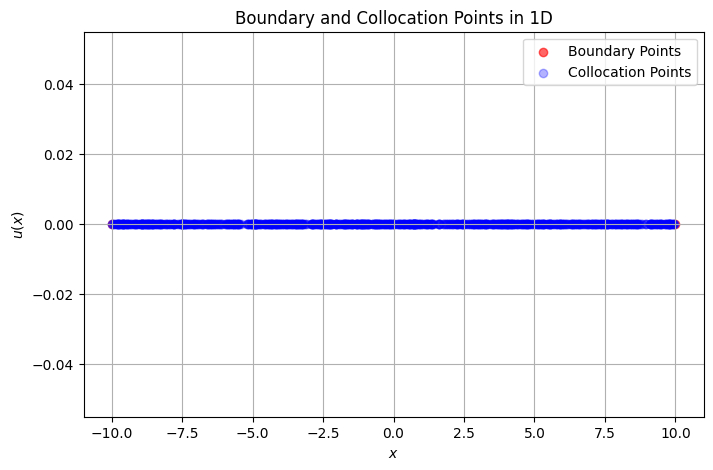

In [10]:
N_u = 2 # Number of boundary points (only needs to be 2 in this example)
N_f = 1000 # Number of collocation points
branch_layers = [10, 100, 100, 100]
trunk_layers = [1, 100, 100, 100]
epochs = 4001

# Instantiate the PINN model and initialize its weights
model = GrossPitaevskiiPINN(branch_layers, trunk_layers).to(device)
model.apply(initialize_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5, verbose=True)

# Generate grid
lb = -10
ub = 10
X = np.linspace(lb, ub, N_f).reshape(-1, 1)

# Prepare training data (collocation and boundary points)
collocation_points, boundary_points, boundary_values = prepare_training_data(N_u, N_f, lb, ub)

# Visualize training data
visualize_training_data_1D(collocation_points, boundary_points, boundary_values)

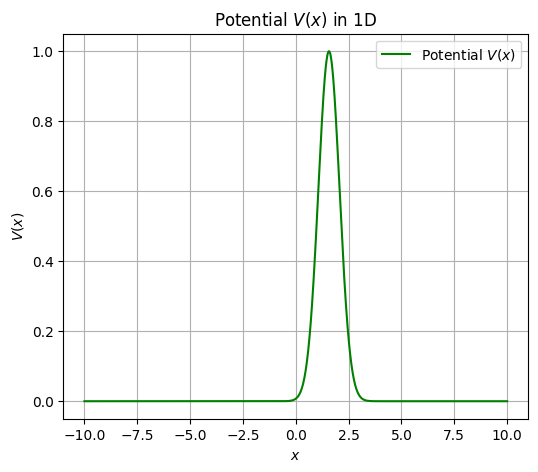

In [11]:
# Visualize the potential
X_test = np.linspace(lb, ub, N_f).reshape(-1, 1)  # Test points along the 1D interval
potential = model.compute_potential(torch.tensor(X_test, dtype=torch.float32).to(device)).detach().cpu().numpy()
plot_potential_1D(X_test, potential)

In [12]:
# Train the PINN

etas = [1, 10, 100, 1000]
Bs = [20000, 20000, 20000, 20000]
Ns = [10000, 10000, 10000, 10000]
models = [GrossPitaevskiiPINN(branch_layers, trunk_layers).to(device) for _ in range(4)]
epochs_list = [8001, 8001, 8001, 8001]
x_train = torch.rand(N_f, 1).to(device)

for model, eta, B, N, epochs in zip(models, etas, Bs, Ns, epochs_list):
  model, X_f_train_tensor, X_u_train_tensor, u_train_tensor = train_physics_informed_deeponet(X, N_u=N_u, N_f=N_f, branch_layers=branch_layers, trunk_layers=trunk_layers, epochs=epochs, eta=eta, B=B, N=N)

<ipython-input-6-100d5e06809d>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  branch_input_tensor = torch.tensor(branch_input, dtype=torch.float32).to(device)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x1 and 10x100)